# Zabavna analiza izračunljivih funkcija

---
    
**KODOVI:**

- zero -> 0
- successor -> 1
- projekcija(n) -> [2,n]
- kompozicija -> [3,g.code,*[h.code for h in hs]]
- primitivna rekurzija -> [4,g.code,h.code]
- minimizacija -> [5,g.code]

## Kratak uvod u izračunljivost
$\newcommand{\code}[1]{\texttt{#1}}$
Posve neformalno, ali dovoljno precizno; kažemo da je funkcija izračunljiva ako je možemo kreirati pomoću inicijalnih funkcija.
Inicijalne funkcije su nula, sljedbenik i projekcija. Alati za kreiranja koje imamo na raspolaganju su kompozicija, primitivna rekurzija i minimizacija.
Sve inicijalne funkcija, kompoziciju, primitivnu rekurziju i minimizaciju napisat ćemo kao objekte sličnih svojstava, te ćemo dodatno definirati i funkcije višeg reda $\code{compose}$, $\code{prim_recurse}$ i $\code{minimize}$ kojima ćemo lako kreirati nove funkcije.

### Nula

Nulu je funkcija koju označujemo sa $\code{Z}$ i definiramo:
$Z : N^k \rightarrow N$,  $Z(\overrightarrow{x}) = 0$

In [403]:
class zero(object):
    code = 0
    def __call__(self,*args):
        return 0
    def __str__(self):
        return 'Z'
    def __eq__(self, other):
        return self.code == other.code

Pogledajmo ponašanje ovog objekta i primijetimo njegova svojstva na sljedećim primjerima.

In [409]:
Z = zero()
print(Z(), Z(3), Z(3,2,5))
print(Z)

0 0 0
Z


### Sljedbenik
Funkciju sljedbenika označujemo sa $\code{S}$ i **inače** definiramo:
$S : N \rightarrow N$, $S(x) = x+1$.
Da bismo izbjegli neželjene greške vezane uz broj argumenata (a želimo kod zadržati koliko-toliko jednostavnim) kad ćemo kreirati sve moguće kombinacije od 1,2,3,... inicijalne funkcije, definirat ćemo funkciju sljedbenika kao: $S : N^k \rightarrow N$, $S(\overrightarrow{x}) = x_1+1$

In [410]:
class successor(object):
    code = 1
    #def: accept even multiple aguments, but work with first
    def __call__(self,*args):
        if len(args) == 0:
            return 0
        return args[0]+1
    def __str__(self):
        return 'S'
    def __eq__(self, other):
        return self.code == other.code

In [411]:
S = successor()
print(S(), S(2), S(2,3,5))
print(S)

0 3 3
S


Projekcija $I : N^k \rightarrow N$, $I(n,\overrightarrow{x}) = x_n$, $1 \leq n \leq k$

In [412]:
class projection(object):
    code = [2]
    def __init__(self,n=1):
        self.n = n
        self.code = [2,n]
    def __call__(self,*args):
        if len(args) == 0:
            return 0
        # def: return last argument if n is out of args bounds
        if len(args) < self.n:
            return args[-1]
        return args[self.n-1]
    def __str__(self):
        return 'I'+str(self.n)
    def __eq__(self, other):
        return self.code == other.code

I2 = projection(2)
print(I2(1,2,3,4))
print(I2.code)
    

2
[2, 2]


### Kompozicija

In [356]:
def compose(g, *hs):
    hs_num = len(hs)
    g_params = [None]*hs_num
    class composition(object):
        code = [3]
        def __init__(self):
            self.code.extend([g.code,*[h.code for h in hs]])
        def __call__(self,*args):
            for i in range(0,hs_num):
                g_params[i] = hs[i](*args)
            return g(*g_params)
        def __str__(self):
            name = '('+str(g)+'¤'
            if(hs_num>1):
                name += '('
            for i in range(0,hs_num-1):
                name += str(hs[i])+','
            name += str(hs[-1])
            if(hs_num>1):
                name += ')'
            return name+')'
        def __eq__(self, other):
            return self.code == other.code
    return composition()
    

In [357]:
test = compose(I2,S,compose(S,Z))
print(test(11))
print(test.code)
print(test)

1
[3, [2, 2], 1, [3, 1, 0]]
(I2¤(S,(S¤Z)))


### Primitivna rekurzija

In [358]:
def prim_recurse(g, h):
    class prim_recursion(object):
        code = [4]
        def __init__(self):
            self.code.extend([g.code,h.code])
        def __call__(self,*args):
            # po definiciji
            if isinstance(args,int):
                # degenerate version
                if args == 0:
                    return g(0)
                return h(args-1,prim_recurse(g,h)(args-1))
            # non-degenerate
            if args[-1] == 0:
                return g(*args[:-1])
            return h(*args[:-1],args[-1]-1,prim_recurse(g,h)(*args[:-1],args[-1]-1))
        def __str__(self):
            return '('+str(g)+"pr"+str(h)+')'
        def __eq__(self, other):
            return self.code == other.code
    return prim_recursion()

In [359]:
I1 = projection(1)
I3 = projection(3)
add = prim_recurse(I1,compose(S,I3))
print(add)
print("9+11="+str(add(9,11)))

pd = prim_recurse(Z,I1)
#print(pd.code)
sub = prim_recurse(I1,compose(pd,I3))
print(sub.code)
print("5-2="+str(sub(5,2)))

(I1pr(S¤I3))
9+11=20
[4, [2, 1], [3, [4, 0, [2, 1]], [2, 3]]]
5-2=3


### Minimizacija

In [360]:
def minimize(g):
    class minimization(object):
        code = [5]
        def __init__(self):
            self.code.append(g.code)
        def __call__(self,*args):
            y = 0
            # po definiciji
            while g(*args,y) != 0: 
                y += 1
                if y > 100:
                    return -1
            return y
        def __str__(self):
            return "min("+str(g)+')'
        def __eq__(self, other):
            return self.code == other.code
    return minimization()

In [361]:
simple = minimize(sub)
print(simple.code)
print(simple(3))

[5, [4, [2, 1], [3, [4, 0, [2, 1]], [2, 3]]]]
3


## Primjeri izračunljivih funkcija

**TODO**
...................

---

In [362]:
I = projection()
f_dict = [Z,S,I]

# creating functions from code
def parse_from_code(code):
    if isinstance(code,int):
        if code == 0:
            return zero()
        if code == 1:
            return successor()
        raise ValueError("In this code position only zero (code 0) and successor (code 1) are allowed.")
    argl = len(code)-1
    if code[0] == 2:
        if argl == 1:
            return projection(code[1])
        raise ValueError("Projection (code 2) must be followed by 1 integer representing its projecting dimension but you provided " + str(argl))
    if code[0] == 3:
        if argl > 1:
            return compose(parse_from_code(code[1]),*[parse_from_code(hc) for hc in code[2:]])
        raise ValueError("Composition (code 3) is defined with at least 2 functions (arguments) but you provided just " + str(argl))
    if code[0] == 4:
        if argl == 2:
            return prim_recurse(parse_from_code(code[1]), parse_from_code(code[2]))
        raise ValueError("Primitive recursion (code 4) is defined with exactly 2 functions (arguments) but you provided " + str(argl))
    if(code[0] == 5):
        if argl == 1:
            return minimize(parse_from_code(code[1]))
        raise ValueError("Minimization (code 5) is defined with exaclty 1 function (argument) but you provided " + str(argl))    
    else:
        raise ValueError("Higher order function codes are: 3,4,5 but you provided " + str(code[0]))

In [363]:
ss = parse_from_code(1)
print(ss(3))

comp_test = compose(S,Z)
print(comp_test.code)
print(parse_from_code(comp_test.code))

ct2 = compose(S,comp_test)
print(ct2.code)
print(parse_from_code(ct2.code))

print(parse_from_code([3,0,1,1,1]))

print(add.code)
print(parse_from_code(add.code))

4
[3, 1, 0]
(S¤Z)
[3, 1, [3, 1, 0]]
(S¤(S¤Z))
(Z¤(S,S,S))
[4, [2, 1], [3, 1, [2, 3]]]
(I1pr(S¤I3))


Radit ćemo s maksimalnom dimenzijom inputa 3

In [365]:
class addo(object):
    function = prim_recurse(I1,compose(S,I3))
    def __init__(self):
        self.code = self.function.code
    def __call__(self,*args):
        return self.function(*args)
    def __str__(self):
        return "add"
    
add = addo()
print(add(2,3))

5


In [400]:
Z = zero()
S = successor()

add = addo()

funs = [Z,S,add]

def all_combinations(n,argnum):
    # add appropriate projections
    for i in range (1,argnum+1):
        funs.append(projection(i))
    # start algorithm
    if n==1:
        return [f for f in funs]
    functions = []
    lowers = all_combinations(n-1,argnum)
    for lf in lowers:
        
        functions.append(minimize(lf))
        
        for f in funs:
            
            c12 = compose(f,lf)
            if c12 not in functions:
                functions.append(c12)
            if lf is not f:
                c21 = compose(lf,f)
                if c21 not in functions:
                    functions.append(c21)
            
            p12 = prim_recurse(f,lf)
            if p12 not in functions:
                functions.append(p12)
            if lf is not f:
                p21 = prim_recurse(lf,f)
                if p21 not in functions:
                    functions.append(p21)
                    
    return functions
    

In [402]:
testfs = all_combinations(2,2)

print("Functions count:", len(testfs))

for tf in testfs:
    if tf(2,3) == 6:
        print(tf, tf(2,5))

print("Done.")

Functions count: 63
(S¤add) 8
Done.


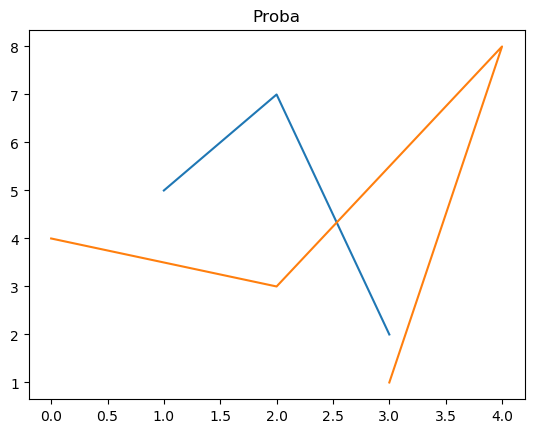

In [390]:
%matplotlib agg

import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Proba')
ax1.plot([1, 2, 3], [5, 7, 2])
ax1.plot([3, 4, 2, 0], [1, 8, 3, 4])
fig1